# **Problema 1 - Detección de idioma**

**Descripción:**

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a oraciones habladas en distintos idiomas.


**Objetivo:**
Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir el idioma correspondiente.

Como paso preliminar, se solicita construir un dataset de clasificación utilizando los siguientes idiomas del set de datos.

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:
*   Modelo convolucional sobre los espectrogramas de los clips.
*   Modelo recurrente sobre los espectrogramas de los clips.


## *Librerías*

In [ ]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!pip install gdown

In [ ]:
pip install pydub

In [ ]:
pip install tensorflow-datasets pandas

In [ ]:
import os
import pathlib
import gdown
import pandas as pd
import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import shutil
import librosa

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


## *Extracción de datos y armado de dataset*

In [ ]:
file_id = "1OI8Op2YGGk3enHQMe5Cy-8fD7gBf7R_2"
gdown.download_folder(f"https://drive.google.com/drive/folders/{file_id}?usp=sharing", output="/content/")

Retrieving folder contents


Processing file 1R59XvWiImoDdG50JEQ-79rK_e_HleJVA idiomas.rar


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1R59XvWiImoDdG50JEQ-79rK_e_HleJVA
From (redirected): https://drive.google.com/uc?id=1R59XvWiImoDdG50JEQ-79rK_e_HleJVA&confirm=t&uuid=d7caf4d6-c697-49f0-bbe7-4f27532b9989
To: /content/TP2-audios/idiomas.rar
100%|██████████| 149M/149M [00:03<00:00, 41.3MB/s]
Download completed


['/content/TP2-audios/idiomas.rar']

In [ ]:
download_path = "/content/TP2-audios"
print(os.listdir(download_path))

['idiomas.rar']


In [ ]:
rar_path = '/content/TP2-audios/idiomas.rar'
output_path = '/content/idiomas'
os.makedirs(output_path, exist_ok=True)

# Descomprimir el archivo .rar
!unrar x -y {rar_path} {output_path}

for root, dirs, files in os.walk(output_path):
    print(f"Directorio: {root}")
    for file in files[:5]:
        print(f"  Archivo: {file}")


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/TP2-audios/idiomas.rar

Creating    /content/idiomas/idiomas                                  OK
Creating    /content/idiomas/idiomas/español                          OK
Extracting  /content/idiomas/idiomas/español/1001744349579669536.wav       0%  OK 
Extracting  /content/idiomas/idiomas/español/1007153953391704970.wav       0%  OK 
Extracting  /content/idiomas/idiomas/español/1009772077090409679.wav       0%  OK 
Extracting  /content/idiomas/idiomas/español/1013105803699497262.wav       0%  OK 
Extracting  /content/idiomas/idiomas/español/1014289795206707108.wav       0%  OK 
Extracting  /content/idiomas/idiomas/español/1021561597309617046.wav       0%  OK 
Extracting  /content/idiomas/idiomas/español/1035178855965321126.wav       1%  OK 
Extracting  /content/idiomas/idiomas/español/1038250874850975162.wav       1%

 Vamos a organizar los datos para procesarlos luego. Vinculamos cada archivo de audio con su etiqueta de idioma.

In [ ]:
base_path = "/content/idiomas/idiomas"

languages = ["frances", "ingles", "japones", "español"]
dataset = []

for lang in languages:
    audio_files = glob.glob(f"{base_path}/{lang}/*.wav")
    for file in audio_files:
        dataset.append({'file_path': file, 'label': lang})


In [ ]:
df = pd.DataFrame(dataset)

print(df.head(250))


                                             file_path    label
0    /content/idiomas/idiomas/frances/1303348582839...  frances
1    /content/idiomas/idiomas/frances/3396633305792...  frances
2    /content/idiomas/idiomas/frances/1081172038867...  frances
3    /content/idiomas/idiomas/frances/6183298823025...  frances
4    /content/idiomas/idiomas/frances/3961133794779...  frances
..                                                 ...      ...
245  /content/idiomas/idiomas/ingles/17736516583922...   ingles
246  /content/idiomas/idiomas/ingles/43835234327747...   ingles
247  /content/idiomas/idiomas/ingles/18224215034495...   ingles
248  /content/idiomas/idiomas/ingles/18218112227545...   ingles
249  /content/idiomas/idiomas/ingles/12567592379566...   ingles

[250 rows x 2 columns]


In [ ]:
organized_audio_dir = "/content/organized_audio"

if os.path.exists(organized_audio_dir):
    shutil.rmtree(organized_audio_dir)
os.makedirs(organized_audio_dir)

Organizo en carpetas

In [ ]:
for lang in languages:
    lang_path = os.path.join(base_path, lang)
    lang_dir = os.path.join(organized_audio_dir, lang)

    os.makedirs(lang_dir)

    audio_files = os.listdir(lang_path)
    for audio_file in audio_files:
        file_path = os.path.join(lang_path, audio_file)

        shutil.copy(file_path, lang_dir)


Vamos a dividir los datos de entrenamiento y validación.

Obtenemos la información de tamaño de los dataset.

In [ ]:
# Ahora que tenemos los audios organizados por carpetas, podemos usar `audio_dataset_from_directory`

# Crear el dataset de entrenamiento y validación
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=organized_audio_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)

print(f"Train dataset size: {len(train_ds)} batches")
print(f"Validation dataset size: {len(val_ds)} batches")

Found 800 files belonging to 4 classes.
Using 640 files for training.
Using 160 files for validation.
Train dataset size: 10 batches
Validation dataset size: 3 batches


Vemos que tenemos 800 audios en total, 640 para training y 160 para validation. Donde tienen 10 batches y 3 batches respectivamente.

Forma y tipo de datos

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Nos aseguramos que todos los datos tengan el formato que necesitamos y mejoramos la eficiencia del pipeline.

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

#train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
#val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

train_ds = train_ds.map(squeeze, num_parallel_calls=4)
val_ds = val_ds.map(squeeze, num_parallel_calls=4)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Vamos a visualizar con que datos estamos trabajando.

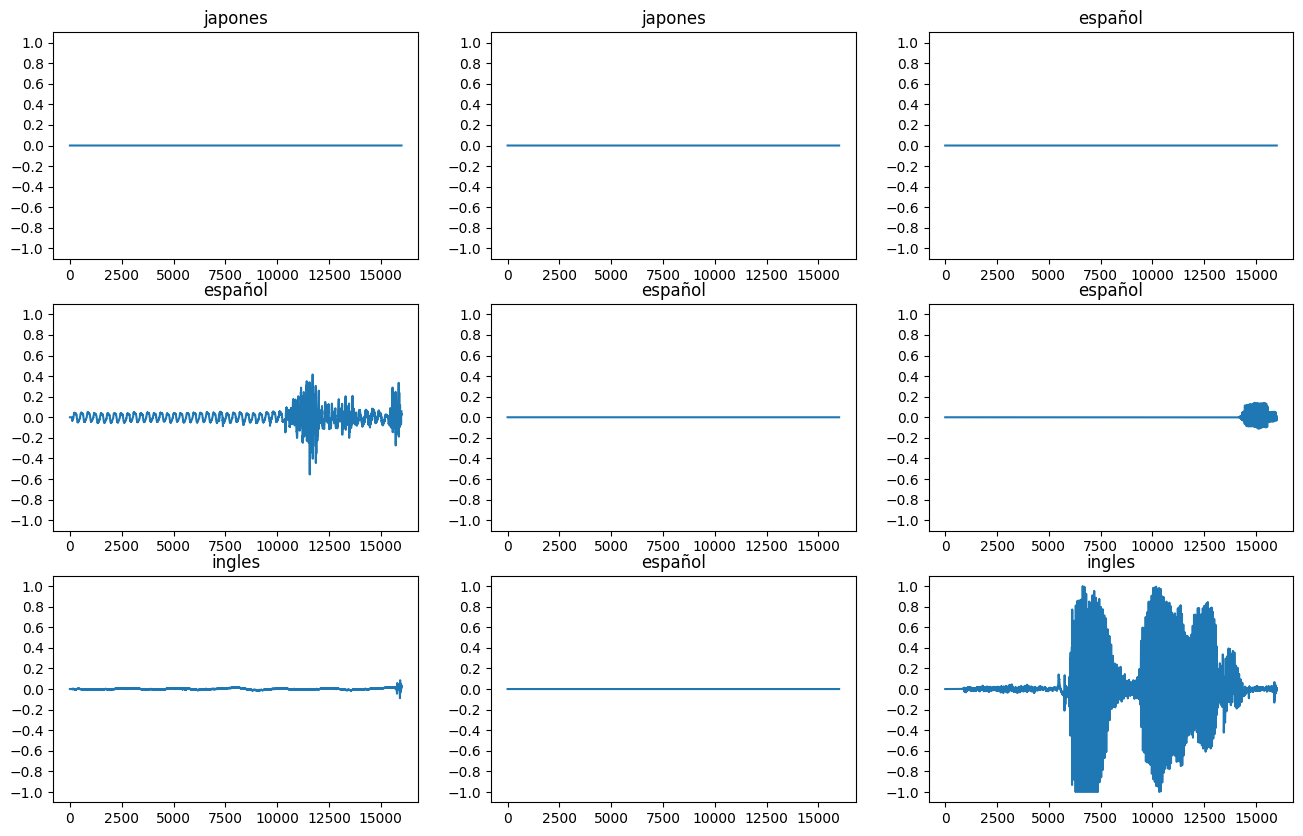

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

Vamos a convertir los audios en una imagen de como las frecuencias cambian con el tiempo.

In [ ]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Verificamos los datos, la forma de los audios, y calculamos espectrograma de unos ejemplos.

In [ ]:
for i in [10, 20, 30]:
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ingles
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: japones
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: español
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

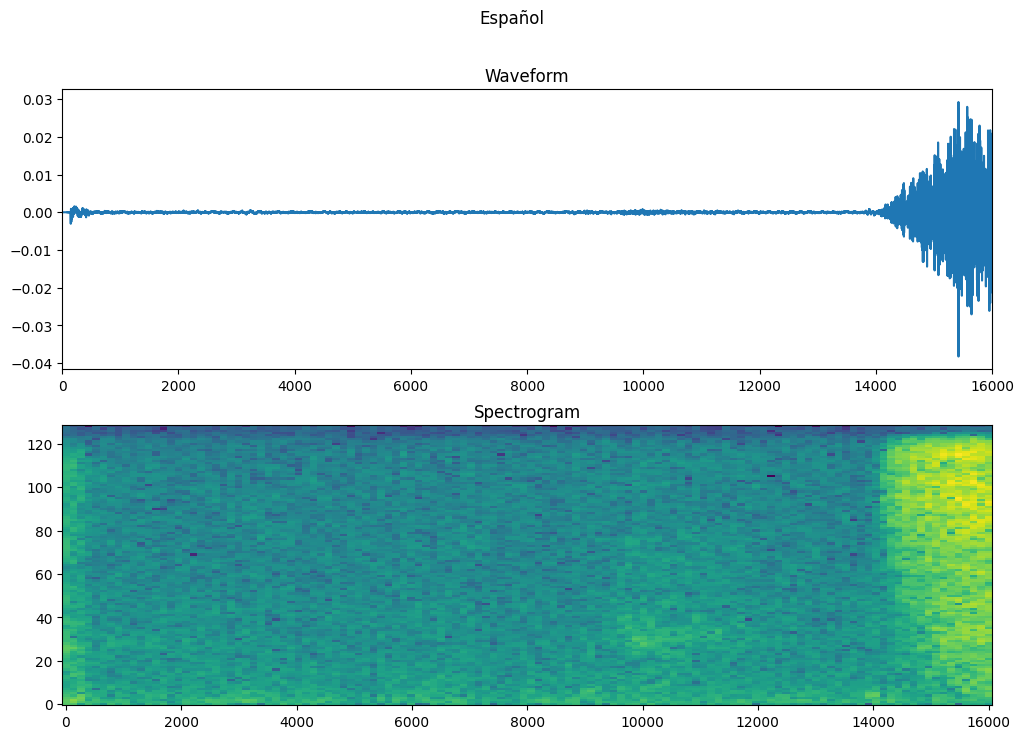

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

 Un espectrograma es una representación visual de cómo varía la energía de diferentes frecuencias a lo largo del tiempo en una señal de audio.

 En el eje Y representa las frecuencias de la señal. En X el tiempo. Los colores la intensidad (mas claros indican mas energía).

Calculo todos los espectogramas

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label)
  )

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

Visualizamos algunos espectogramas

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

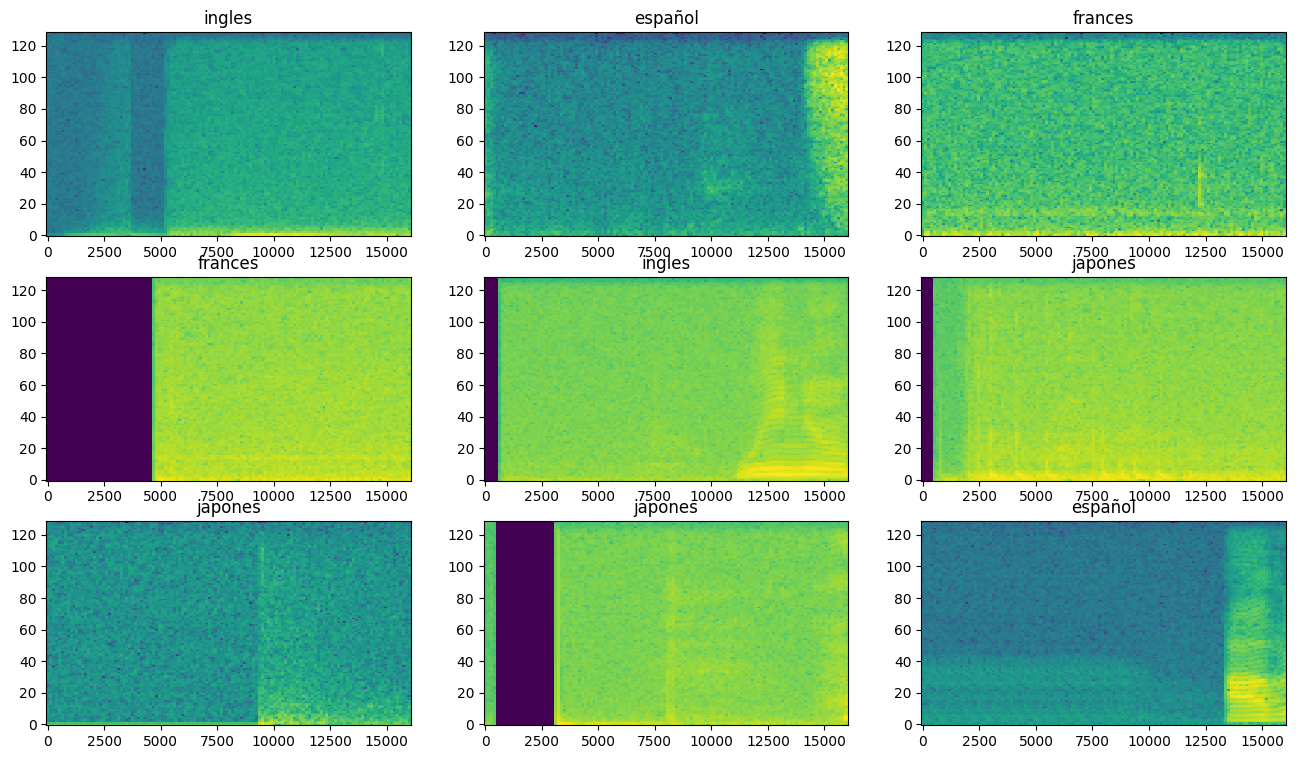

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Los rectangulos violeta podrían indicar ruido, silencio o interferencia.

# Modelo CNN

Utilizamos cache() para almacenar los datos en memoria, shuffle(10000) para aleatorizar los datos, y prefetch(tf.data.AUTOTUNE) para hacer que el entrenamiento más eficiente.

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Usamos una red neuronal convolucional para clasificar entre los audios de 4 idiomas.

Lo componemos de dos capas convolucionales con capas de max-pooling, normalización de los datos de entrada, una capa densa y una capa de salida con softmax. El proceso de entrenamiento optimiza el modelo usando la entropía cruzada como función de pérdida y la precisión como métrica.

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_conv = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Resizing(32, 32),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model_conv.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Entrenar el modelo
history_conv = model_conv.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=50,
)


Input shape: (124, 129, 1)
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.3099 - loss: 1.3619 - val_accuracy: 0.3438 - val_loss: 1.3224
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4290 - loss: 1.2720 - val_accuracy: 0.3938 - val_loss: 1.3029
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4951 - loss: 1.2097 - val_accuracy: 0.4187 - val_loss: 1.2809
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5208 - loss: 1.1604 - val_accuracy: 0.4187 - val_loss: 1.2936
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5666 - loss: 1.0993 - val_accuracy: 0.4437 - val_loss: 1.2913
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5909 - loss: 1.0533 - val_accuracy: 0.4125 - val_loss: 1.3105
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5758 - loss: 1.0280 - val_accuracy: 0.4313 - val_loss: 1.3098
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5853 - loss: 1.0195 - val

Text(0, 0.5, 'Accuracy [%]')

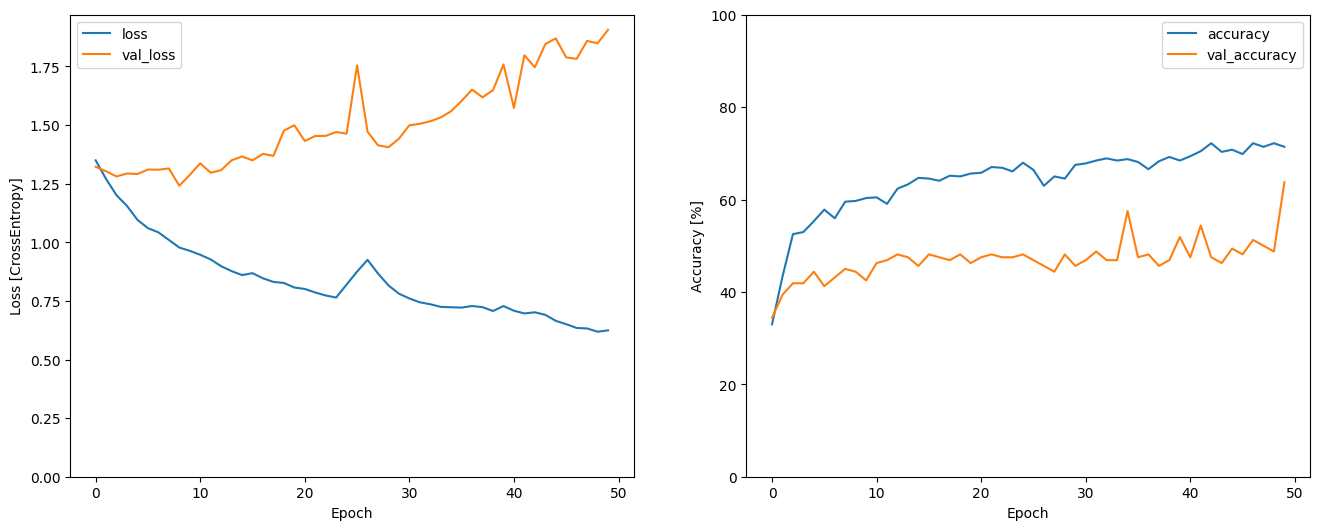

In [ ]:
metrics = history_conv.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_conv.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_conv.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Logramos un accuracy de 0.64 en train prediciendo el 64% de los datos correctamente.

La perdida lograda es de 0,6.

Nos indica un modelo que ajusta bien a los datos, con buenas metricas de validacion y train.

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step


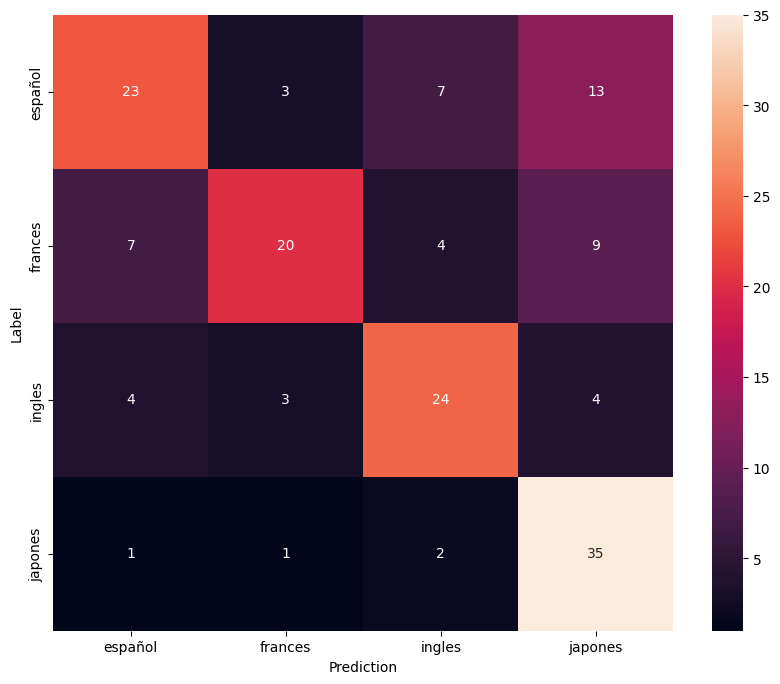

In [ ]:
y_pred = model_conv.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

***Interpretación del grafico:***

*Predicciones correctas:*

Japonés: 35 veces predicho como japonés.

Inglés: 24 veces predicho como inglés.

Francés: 20 veces predicho como francés.

Español: 23 veces predicho como español.



*Errores de clasificación:*

Japonés: Predicho como:
Español: 13 veces,
Francés: 9 veces,
Inglés: 4 vez.

Inglés: Predicho como:
Francés: 4 veces,
Español: 7 veces,
Japonés: 2 veces.

Francés: Predicho como:
Inglés: 3 veces,
Japonés: 1 veces,
Español: 3 veces.

Español: Predicho como:
Japonés: 1 veces,
Inglés: 4 veces,
Francés: 7 veces.


*Conclusión:*

Japonés tiene una buena tasa de predicción, pero se confunde principalmente con Español.

Inglés y Francés tienen una confusión importante, especialmente Francés predicho como Inglés.

Español es el que tiene la peor tasa de clasificación.

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=label_names)
print(report)

              precision    recall  f1-score   support

     español       0.66      0.50      0.57        46
     frances       0.74      0.50      0.60        40
      ingles       0.65      0.69      0.67        35
     japones       0.57      0.90      0.70        39

    accuracy                           0.64       160
   macro avg       0.66      0.65      0.63       160
weighted avg       0.66      0.64      0.63       160



***Métricas:***

*Español:*

Precisión: 66% de las predicciones son correctas.
Recall: 50% del total de las predicciones.
F1-Score: 0.57 Rendimiento moderado en la clasificación de español.

*Francés:*

Precisión: 74% de las predicciones son correctas.
Recall: 50% del total de las predicciones.
F1-Score: 0.60 Rendimiento sólido en francés.

*Inglés:*

Precisión: 65% de las predicciones son correctas.
Recall: 69% del total de las predicciones.
F1-Score: 0.67 - Buen rendimiento en inglés.

*Japonés:*

Precisión: 57% de las predicciones son correctas.
Recall: 90% del total de las predicciones.
F1-Score: 0.70 - Rendimiento moderado.


*Resumen general:*

Precisión promedio: el 66% de las predicciones fueron correctas.
Recall promedio: el modelo logra identificar correctamente el 64% de los casos en total.
F1-Score promedio ponderado: desempeño moderado en la clasificación global del modelo.

*Conclusión:*
Japonés es la clase más difícil de predecir, probablemente por confusión con otras clases.
Francés también tiene el más alto rendimiento.
Inglés y Español muestran un buen rendimiento.

# Modelo RNN

In [ ]:
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

Vamos a convertir en espectograma, preprocesar los datos y normalizarlos para visualizar.

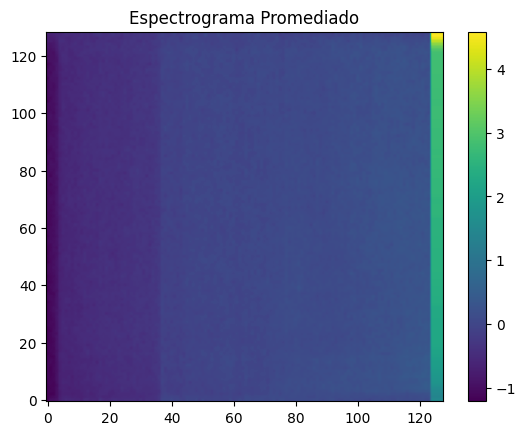

In [ ]:
# Función para convertir audio en espectrograma
def audio_to_spectrogram(audio, sample_rate=16000):
    spectrogram = tf.signal.stft(audio, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.log(spectrogram + 1e-6)
    return spectrogram

# Longitud fija de frames para el espectrograma
FIXED_FRAME_LENGTH = 128

@tf.function
def preprocess(audio, label):
    spectrogram = audio_to_spectrogram(audio)
    spectrogram = tf.pad(
        spectrogram,
        [[0, 0], [0, tf.maximum(0, FIXED_FRAME_LENGTH - tf.shape(spectrogram)[1])], [0, 0]]
    )

    spectrogram = spectrogram[:, :FIXED_FRAME_LENGTH, :]

    return spectrogram, label

# Preprocesar los datasets
train_spectrogram_ds = train_ds.map(preprocess)
val_spectrogram_ds = val_ds.map(preprocess)

norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))

train_spectrogram_ds = train_spectrogram_ds.map(lambda spec, label: (norm_layer(spec), label))
val_spectrogram_ds = val_spectrogram_ds.map(lambda spec, label: (norm_layer(spec), label))

for spec, label in train_spectrogram_ds.take(1):
    spec = tf.reduce_mean(spec, axis=0)
    spec = tf.transpose(spec)
    plt.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    plt.title("Espectrograma Promediado")
    plt.colorbar()
    plt.show()



Vamos a elaborar y entrenar un modelo RNN con capas LSTM para clasificar los datos de espectrogramas, con un optimizador Adam, una función de pérdida de entropía cruzada para clasificación multiclase y el callback para ajustar la tasa de aprendizaje durante el entrenamiento.

In [ ]:
input_shape = (None, train_spectrogram_ds.element_spec[0].shape[1])
num_labels = len(label_names)

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

model_rnn = models.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_labels, activation='softmax')
])

# Compilar el modelo
model_rnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Entrenar el modelo
history_rnn = model_rnn.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=40,
    callbacks=[lr_callback]
)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.2797 - loss: 1.4206 - val_accuracy: 0.3625 - val_loss: 1.3516 - learning_rate: 0.0010
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.3257 - loss: 1.3482 - val_accuracy: 0.2812 - val_loss: 1.3335 - learning_rate: 0.0010
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.3546 - loss: 1.3169 - val_accuracy: 0.4250 - val_loss: 1.2642 - learning_rate: 0.0010
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.4395 - loss: 1.2521 - val_accuracy: 0.4437 - val_loss: 1.1989 - learning_rate: 0.0010
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.4222 - loss: 1.2370 - val_accuracy: 0.4500 - val_loss: 1.1558 - learning_rate: 0.0010
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.4624 - loss: 1.1726 - val_accuracy: 0.5250 - val_loss: 1.1032 - learning_rate: 0.0010
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.4801 - loss: 1.1341 - v

Text(0, 0.5, 'Accuracy [%]')

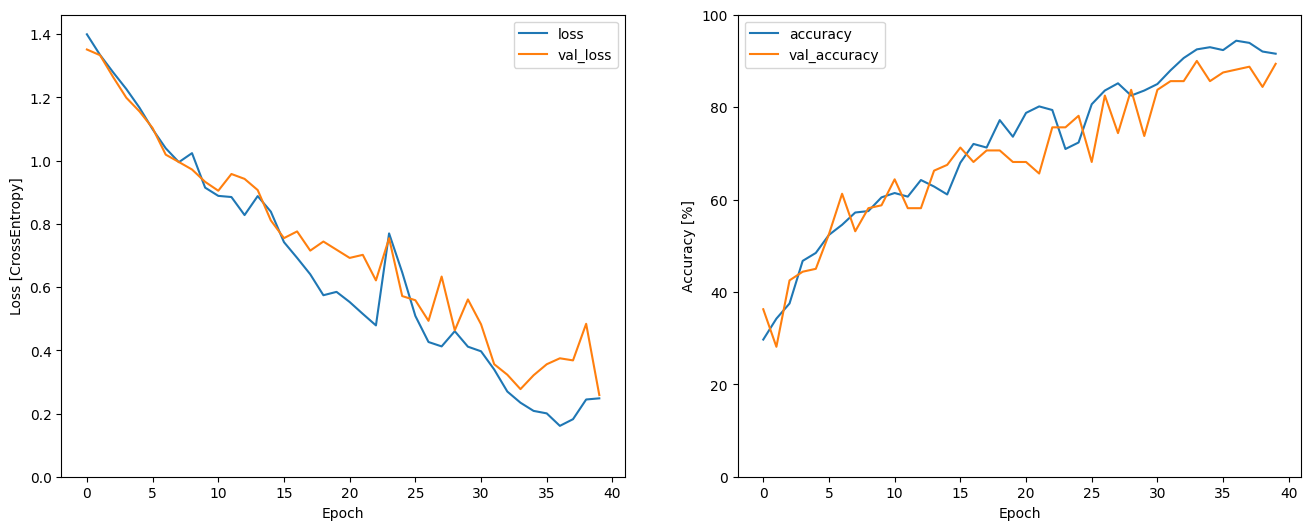

In [ ]:
metrics = history_rnn.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_rnn.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_rnn.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Logramos un accuracy de 0.89 en train prediciendo el 89% de los datos correctamente.

La perdida lograda es de 0,25.

Nos indica un modelo que ajusta bien a los datos, con buenas metricas de validacion y train y poco overfitting en general.

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


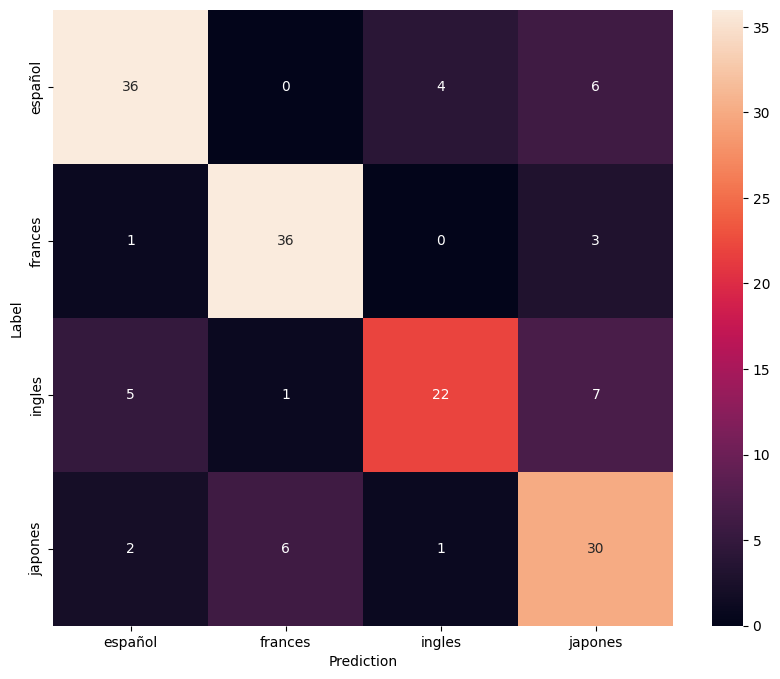

In [ ]:
y_pred = model_rnn.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

***Interpretación del grafico:***

*Predicciones correctas:*

Japonés: 30 veces predicho como japonés.

Inglés: 22 veces predicho como inglés.

Francés: 36 veces predicho como francés.

Español: 36 veces predicho como español.



*Errores de clasificación:*

Japonés: Predicho como:
Español: 2 veces,
Francés: 6 veces,
Inglés: 1 veces.

Inglés: Predicho como:
Francés: 1 veces,
Español: 5 veces,
Japonés: 7 veces.

Francés: Predicho como:
Inglés: 0 veces,
Japonés: 3 veces,
Español: 1 veces.

Español: Predicho como:
Japonés: 6 veces,
Inglés: 4 veces,
Francés: 0 veces.


*Conclusión:*

En general todos los idiomas fueron predichos bien y sin sesgos considerables.

In [ ]:
report = classification_report(y_true, y_pred, target_names=label_names)
print(report)

              precision    recall  f1-score   support

     español       0.82      0.78      0.80        46
     frances       0.84      0.90      0.87        40
      ingles       0.81      0.63      0.71        35
     japones       0.65      0.77      0.71        39

    accuracy                           0.78       160
   macro avg       0.78      0.77      0.77       160
weighted avg       0.78      0.78      0.77       160



***Métricas:***

*Español:*

Precisión: 82% de las predicciones son correctas.
Recall: 78% del total de las predicciones.
F1-Score: 0.80. Rendimiento alto en español.

*Francés:*

Precisión: 84% de las predicciones son correctas.
Recall: 90% del total de las predicciones.
F1-Score: 0.87. Excelente rendimiento en francés.

*Inglés:*

Precisión: 81% de las predicciones son correctas.
Recall: 63% del total de las predicciones.
F1-Score: 0.71. Rendimiento moderado en inglés.

*Japonés:*
Precisión: 65% de las predicciones son correctas.
Recall: 77% del total de las predicciones.
F1-Score: 0.71. Rendimiento moderado en japonés.

*Resumen general:*

Precisión promedio: el 78% de las predicciones fueron correctas.
Recall promedio: el modelo logra identificar correctamente el 77% de los casos en total.
F1-Score promedio: 0.77, muy buen desempeño en la clasificación global del modelo.

*Conclusión:*

El modelo RNN fue muy superior al modelo convolucional utilizando solo 2 capas.

# **Conclusión:**

La RNN con capas LSTM mostró un rendimiento superior en comparación con el modelo CNN, con un F1-score de 0.72 frente a 0.57. Esto se debe a que las RNN son capaces de capturar dependencias temporales y patrones en los datos espectrográficos, siendo esencial para la clasificación de secuencias de audio.

El modelo RNN alcanzó una mayor precisión y recall en la clasificación de japonés y francés, especialmente en la identificación de las clases difíciles. Esto se debe a la capacidad de las LSTM para manejar mejor las secuencias de datos temporales.

Por otro lado, aunque la RNN mostró una mejora en el rendimiento global, también se notó que la confusión en la clasificación de español e inglés persiste, lo que podría indicar que, aunque las RNN tienen una ventaja sobre las CNN en este tipo de tareas, aún es necesario ajustar y mejorar la capacidad de discriminación entre clases similares.

En resumen, la RNN con LSTM logró un rendimiento notablemente superior al de la CNN, especialmente en tareas que requieren entender las relaciones temporales dentro de los espectrogramas, lo que la hace más adecuada para este tipo de clasificación de audio secuencial. Sin embargo, aún hay margen para mejorar el rendimiento en algunas clases, como inglés y español.